### Importing Required Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.
C:\Users\susya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\susya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\susya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\susya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Importing and Analyzing the Dataset

In [2]:
movie_review_data = pd.read_csv("C:/Users/susya/IMDB.csv")

In [3]:
movie_review_data.isnull().values.any()

False

In [4]:
movie_review_data.shape

(50000, 2)

In [5]:
movie_review_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
movie_review_data["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

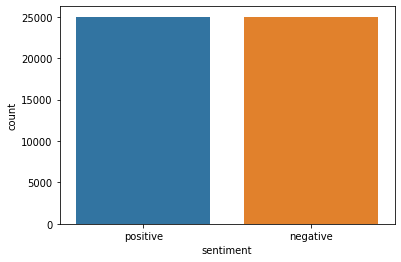

In [7]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_review_data)

### Data Preprocessing

In [8]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [10]:
X = []
sentences = list(movie_review_data['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [11]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [12]:
y = movie_review_data['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

### Now we'll divide our dataset into training and testing set

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In this above code we divide our data into 80% for the training set and 20% for the testing set.

### Preparing the Embedding Layer

###### The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras.
As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

print(vocab_size)

92547


In [16]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
len(X_train)

40000

In [18]:
len(X_test)

10000

We will use GloVe embeddings to create our feature matrix.
In this we load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.

In [19]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('C:/Users/susya/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [20]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Text Classification with Simple Neural Network
The first deep learning model that we are going to develop is a simple deep neural network.

In [21]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [23]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 4s 115us/step - loss: 0.6052 - acc: 0.6687 - val_loss: 0.5377 - val_acc: 0.7311
Epoch 2/6
32000/32000 [==============================] - 3s 83us/step - loss: 0.4934 - acc: 0.7653 - val_loss: 0.5164 - val_acc: 0.7458
Epoch 3/6
32000/32000 [==============================] - 3s 87us/step - loss: 0.4606 - acc: 0.7828 - val_loss: 0.5200 - val_acc: 0.7434
Epoch 4/6
32000/32000 [==============================] - 3s 86us/step - loss: 0.4375 - acc: 0.7989 - val_loss: 0.5273 - val_acc: 0.7414
Epoch 5/6
32000/32000 [==============================] - 3s 83us/step - loss: 0.4196 - acc: 0.8094 - val_loss: 0.5251 - val_acc: 0.7461
Epoch 6/6
32000/32000 [==============================] - 2s 76us/step - loss: 0.4090 - acc: 0.8142 - val_loss: 0.5520 - val_acc: 0.7368


###### To evaluate the performance of the model, we can simply pass the test set to the evaluate method of our model.

In [25]:
score = model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 1s 91us/step


###### Now we can check the test accuracy and loss, 

In [26]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.555546994972229
Test Accuracy: 0.7361000180244446


###### As we can see that we get a test accuracy of 73.61%.

###### Now we plot the loss and accuracy differences for training and test sets.

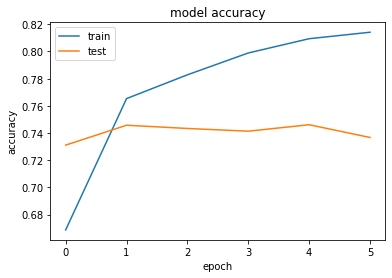

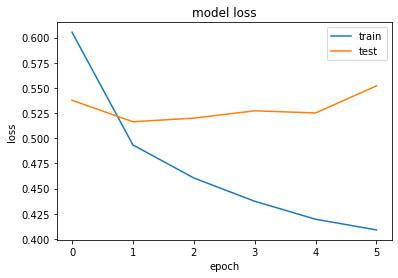

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

## Text Classification with a Convolutional Neural Network

We create a simple convolutional neural network with 1 convolutional layer and 1 pooling layer.

In [28]:
from keras.layers.convolutional import Conv1D

model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [29]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [30]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 29s 909us/step - loss: 0.5036 - acc: 0.7489 - val_loss: 0.3967 - val_acc: 0.8202- loss: 
Epoch 2/6
32000/32000 [==============================] - 27s 855us/step - loss: 0.3767 - acc: 0.8343 - val_loss: 0.3981 - val_acc: 0.8139
Epoch 3/6
32000/32000 [==============================] - 27s 838us/step - loss: 0.3232 - acc: 0.8637 - val_loss: 0.3507 - val_acc: 0.8451
Epoch 4/6
32000/32000 [==============================] - 28s 880us/step - loss: 0.2825 - acc: 0.8865 - val_loss: 0.3555 - val_acc: 0.8403
Epoch 5/6
32000/32000 [==============================] - 28s 876us/step - loss: 0.2456 - acc: 0.9053 - val_loss: 0.3559 - val_acc: 0.8434
Epoch 6/6
32000/32000 [==============================] - 28s 877us/step - loss: 0.2140 - acc: 0.9232 - val_loss: 0.3724 - val_acc: 0.8349


In [31]:
score = model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 6s 568us/step


In [32]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.37074004287719725
Test Accuracy: 0.8346999883651733


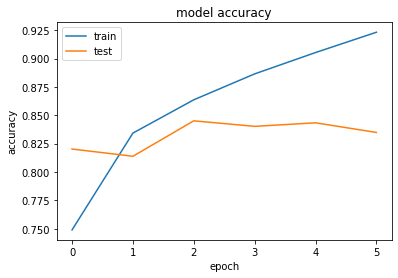

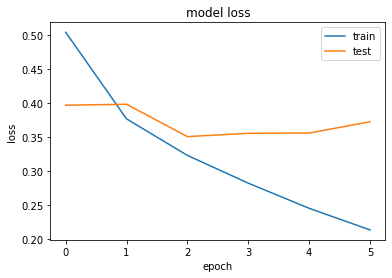

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

## Text Classification with Recurrent Neural Network (LSTM)

In [34]:
from keras.layers import Dense,LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [35]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [36]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 143s 4ms/step - loss: 0.5743 - acc: 0.6962 - val_loss: 0.4551 - val_acc: 0.7919
Epoch 2/6
32000/32000 [==============================] - 141s 4ms/step - loss: 0.4465 - acc: 0.7922 - val_loss: 0.4091 - val_acc: 0.8096
Epoch 3/6
32000/32000 [==============================] - 144s 4ms/step - loss: 0.3941 - acc: 0.8197 - val_loss: 0.3870 - val_acc: 0.8269
Epoch 4/6
32000/32000 [==============================] - 141s 4ms/step - loss: 0.3663 - acc: 0.8367 - val_loss: 0.3632 - val_acc: 0.8396
Epoch 5/6
32000/32000 [==============================] - 139s 4ms/step - loss: 0.3471 - acc: 0.8455 - val_loss: 0.3551 - val_acc: 0.8464
Epoch 6/6
32000/32000 [==============================] - 139s 4ms/step - loss: 0.3307 - acc: 0.8543 - val_loss: 0.3441 - val_acc: 0.8485


In [37]:
score = model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 27s 3ms/step


In [38]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34325622944831846
Test Accuracy: 0.847599983215332


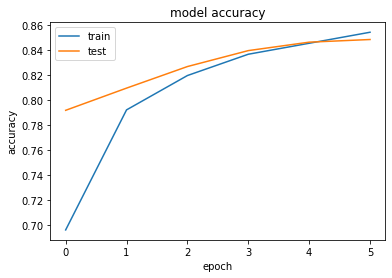

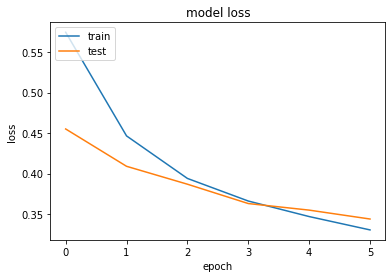

In [39]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Making Predictions on Single Instance

In [40]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [41]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.76562786]], dtype=float32)

###### Remember, we mapped the positive outputs to 1 and the negative outputs to 0.
###### However, the sigmoid function predicts floating value between 0 and 1.
###### If the value is less than 0.5, the sentiment is considered negative where as if the value is greater than 0.5, the sentiment is considered as positive.
###### The sentiment value for our single instance is 0.57 which means that our sentiment is predicted as positive, which actually is the case.